In [1]:
import os
from PIL import Image
import utils

In [2]:
os.chdir('/home/wk/gluon_ws/myDetection/')
os.getcwd()

'/home/wk/gluon_ws/myDetection'

In [3]:
os.environ['data_root']=data_root='./dataset/data'

In [4]:
print(data_root)

./dataset/data


In [5]:
# os.chdir('/home/wk/gluon_ws/')
os.getcwd()
resize = (512,512)

In [6]:
for imgname in os.listdir(data_root+'/img'):
    imgpath = data_root + "/img/" + imgname
    img = Image.open(imgpath)
    img = img.resize(resize, Image.BILINEAR)
    utils.mkdir_if_not_exist(data_root + '/'+'img%d_%d' % (resize[0], resize[1]))
    img.save(data_root + '/' + 'img%d_%d' % (resize[0], resize[1]) + "/" + imgname)
    break

In [7]:

'img%d_%d'%(resize[0],resize[1])
data_root
data_root + '/'+'img%d_%d' % (resize[0], resize[1])

'./dataset/data/img512_512'

In [8]:
with open(data_root+'/rec/img_512_512_val.lst') as f:
    contents = f.read().split('\n')
    for content in contents:
        if content == '':
            break
        content = content.split('\t')
        print(content)
        idx = content[0]
        file = content[-1][:-3] + 'xml'
        print(content[-1][:-3])
        break

['64', '2', '5', '0', '0.358750', '0.502000', '0.505250', '0.902000', 'IMG_20180203_120855.jpg']
IMG_20180203_120855.


In [9]:
from utils import parse_voc_xml
file = 'IMG_20180203_120557.xml'
bndboxs, names, filename = parse_voc_xml(data_root + '/labels/' + file)

In [10]:
bndboxs
filename

'IMG_20180203_120557.jpg'

In [11]:
## lst format
data = idx + '\t2\t5\t'
class_names = ['papercup']
context=''
for bndbox, name in zip(bndboxs,names):
    data += '%d\t%f\t%f\t%f\t%f\t'%(class_names.index(name),bndbox[0],bndbox[1],bndbox[2],bndbox[3])
#     data += filename+'\t'
context += data +filename+'\n' 
# print(data)
print(context)

64	2	5	0	0.168750	0.132000	0.385250	0.633500	0	0.515750	0.167500	0.692250	0.599000	IMG_20180203_120557.jpg



In [12]:
context


'64\t2\t5\t0\t0.168750\t0.132000\t0.385250\t0.633500\t0\t0.515750\t0.167500\t0.692250\t0.599000\tIMG_20180203_120557.jpg\n'

In [13]:
line = [i.strip() for i in context.strip().split('\t')]
line

['64',
 '2',
 '5',
 '0',
 '0.168750',
 '0.132000',
 '0.385250',
 '0.633500',
 '0',
 '0.515750',
 '0.167500',
 '0.692250',
 '0.599000',
 'IMG_20180203_120557.jpg']

In [14]:
item = [int(line[0])] + [line[-1]] + [float(i) for i in line[1:-1]]

In [15]:
z=zip(bndboxs,names)
for i in z:
    print(i)

([0.16875, 0.132, 0.38525, 0.6335], 'papercup')
([0.51575, 0.1675, 0.69225, 0.599], 'papercup')


In [16]:
l = ['aa','bb']
l.index('bb')

1

In [17]:

from mxnet import image
import numpy as np
import mxnet as mx
from utils import show_images

data_shape = (3,512,512)
batch_size = 2
std = np.array([58.395, 57.12, 57.375])
rgb_mean = np.array([130.063048, 129.967301, 124.410760])
ctx = mx.gpu(0)
resize = (512,512)

def get_iterators(rec_prefix, data_shape, batch_size):
    class_names = ['papercup']
    num_class = len(class_names)
    train_iter = image.ImageDetIter(
        batch_size=batch_size,
        data_shape=data_shape,
        path_imgrec=rec_prefix + '_train.rec',
        path_imgidx=rec_prefix + '_train.idx',
        shuffle=True,
        mean=True,
        std=True,
# 
        pad_val=(rgb_mean[0], rgb_mean[1], rgb_mean[2]),
#         min_object_covered=0.95,
#         max_attempts=200,
#         brightness=0.2,
#         contrast=0.2,
#         saturation=0.2,
#         hue=0.05,
#         aspect_ratio_range=(0.5, 2),
#         pca_noise=0.01,
    )

    valid_iter = image.ImageDetIter(
        batch_size=batch_size,
        data_shape=data_shape,
        path_imgrec=rec_prefix + '_val.rec',
        shuffle=False,
        mean=True,
        std=True
    )

    return train_iter, valid_iter, class_names, num_class
    

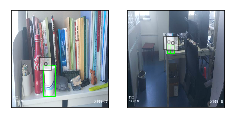

(2, 2, 5)


In [18]:
rec_prefix = './dataset/data/rec/img_'+str(resize[0])+'_'+str(resize[1])
train_data,val_data,class_names,num_class=get_iterators(rec_prefix,data_shape,batch_size)
train_data.reset()
batch=train_data.next()
images = batch.data[0][:]
labels = batch.label[0][:]
show_images(images.asnumpy(),labels.asnumpy(),rgb_mean,std,show_text=True,fontsize=6,MN=(2,4))

print(labels.shape)

In [19]:
from mxnet import gluon
from mxnet.gluon import nn
from mxnet.gluon import model_zoo
from mxnet.ndarray.contrib import MultiBoxPrior
from mxnet import ndarray as nd
import mxnet as mx

def get_alexnet_conv(ctx):
    alexnet = model_zoo.vision.alexnet(pretrained=True,ctx=ctx)
    net = nn.HybridSequential()
    net.add(*(alexnet.features[:8]))
    return net

def down_sample(num_filter):
    out = nn.HybridSequential()
    # extract features which used to output as SSD
    for _ in range(2):
        out.add(nn.Conv2D(num_filter,kernel_size=3,strides=1,padding=1))
        out.add(nn.BatchNorm())
        out.add(nn.Activation('relu'))
    out.add(nn.MaxPool2D(pool_size=2))
    return out 

In [20]:
x = nd.random_normal(shape=(16,3,32,32))
net = down_sample(8)
net.initialize()
out = net(x)

out.shape

(16, 8, 16, 16)

In [21]:

#classify: anchors*(num_classes+1)
def class_predictor(num_class,num_anchors):
    return nn.Conv2D(num_anchors*(num_class+1),kernel_size=3,strides=1,padding=1)

#regression: anchors*4
def box_predictor(num_anchors):
    return nn.Conv2D(num_anchors*4,kernel_size=3,strides=1,padding=1)



In [22]:
#anchor box (need kmeans)
# sizes_list = [[0.10416667, 0.17361111], [0.18624024, 0.34354575], [.37, .619],
#               [.71, .79], [.88, .961]]
sizes_list = [[0.17720574, 0.23724939], [0.30426919, 0.40458742], [.37, .619],
              [.71, .79], [.88, .961]]

ratios_list = [[1,2,.5]]*len(sizes_list)
anchors=[]
x = nd.random.uniform(shape=(1,3,40,40))


In [23]:
for i in range(len(sizes_list)):
    anchors.append(MultiBoxPrior(x,sizes=sizes_list[i],ratios=ratios_list[i]))    
len(anchors)
# anchors[5]

5

In [24]:
anchors[-1].shape

(1, 6400, 4)

In [25]:
y = MultiBoxPrior(x,sizes=sizes_list[0],ratios=ratios_list[4])
y


[[[-0.07610287 -0.07610287  0.10110287  0.10110287]
  [-0.1061247  -0.10612469  0.13112471  0.13112469]
  [-0.11280337 -0.05015169  0.13780338  0.0751517 ]
  ..., 
  [ 0.86887532  0.86887532  1.10612476  1.10612476]
  [ 0.86219662  0.92484832  1.11280334  1.05015171]
  [ 0.92484832  0.86219662  1.05015171  1.11280346]]]
<NDArray 1x6400x4 @cpu(0)>

In [26]:
box = y.reshape((40,40,-1,4))
box.shape

(40, 40, 4, 4)

In [27]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 60
import matplotlib.pyplot as plt

# def box_to_rec(box,color,linewidth=2):
#     box = box.asnumpy()
#     return plt.Rectangle(box[0],box[1],box[2]-box[0],box[3]-box[1],fill=False,edgecolor=color,linewidth=linewidth)

In [28]:
def box_to_rect(box, color, linewidth=3):
    """convert an anchor box to a matplotlib rectangle"""
    box = box.asnumpy()
    return plt.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1],
                         fill=False, edgecolor=color, linewidth=linewidth)


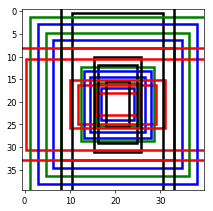

In [29]:
colors=['blue','green','red','black','magenta']
plt.imshow(nd.ones((40,40,3)).asnumpy())

for j in range(len(anchors)): 
    box = anchors[j].reshape((40,40,-1,4))
    bbox=box[20,20,:,:]
    for i in range(bbox.shape[0]):
        plt.gca().add_patch(box_to_rect(bbox[i,:]*40,colors[i]))
#         print(bbox[i,:]*40)
plt.show()

In [30]:
# batch.data[0]

In [31]:
import model
from mxnet.ndarray.contrib import MultiBoxTarget, MultiBoxPrior
# x = nd.random_normal(shape=(1,3,32,32))
x = batch.data[0].as_in_context(mx.gpu(0))
label = batch.label[0].as_in_context(mx.gpu(0))
print(x.shape,label.shape)
net = model.SSD(num_class=1,verbose=True)
_anchor,_box_preds,_cls_preds = net(x)
_cls_preds.shape

(2, 3, 512, 512) (2, 2, 5)
predict scale  0 (2, 256, 64, 64)  with  (1, 16384, 4)  anchors
predict scale  1 (2, 128, 32, 32)  with  (1, 4096, 4)  anchors
predict scale  2 (2, 128, 16, 16)  with  (1, 1024, 4)  anchors
predict scale  3 (2, 128, 8, 8)  with  (1, 256, 4)  anchors
predict scale  4 (2, 128, 1, 1)  with  (1, 4, 4)  anchors


(2, 21764, 2)

In [32]:
box_offset,box_mask,cls_labels = MultiBoxTarget(_anchor,batch.label[0].as_in_context(mx.gpu(0)),_cls_preds.transpose((0,2,1)))

In [33]:
box_offset.shape,box_mask.shape,cls_labels.shape

((2, 87056), (2, 87056), (2, 21764))

In [34]:
from train import *
box_loss = SmoothL1Loss()
cls_loss = FocalLoss()

In [35]:
train_data1,valid_data1,class_names1,num_classes1 = get_iterators(rec_prefix,data_shape,batch_size)

In [36]:
# train_data1.next().label[0][0].shape[0]
valid_data1.next().label[0][0].shape[0]

2

In [37]:
if train_data1.next().label[0][0].shape[0] < 3:
    train_data1.reshape(label_shape=(3, 5))
    valid_data1.reshape(label_shape=(3, 5))
# valid_data1=train_data1.sync_label_shape(valid_data1)
# valid_data1.next().label[0].shape

In [38]:
# valid_data1.label_shape
# train_data1.label_shape
print(train_data1.next().label[0][0])
valid_data1.reset()
valid_data1.next().label[0][0]


[[ 0.          0.67629874  0.24200748  0.79075515  0.79235953]
 [-1.         -1.         -1.         -1.         -1.        ]
 [-1.         -1.         -1.         -1.         -1.        ]]
<NDArray 3x5 @cpu(0)>



[[ 0.          0.35874999  0.50199997  0.50524998  0.90200001]
 [-1.         -1.         -1.         -1.         -1.        ]
 [-1.         -1.         -1.         -1.         -1.        ]]
<NDArray 3x5 @cpu(0)>

In [39]:
net1 = model.SSD(num_class=1,verbose=True)
# net1.hybridize()

In [40]:
# mytrain(net1,train_data1,0,200,cls_loss,box_loss)

In [41]:
# train_data.reset()
# # train_data.next().label[0]
# for batch in train_data:
#     data = batch.data[0]
#     label = batch.label[0]
#     print(label.shape)
#     break
batch1 = train_data1.next()
data1 = batch1.data[0][:].as_in_context(mx.gpu(0)) 
label1 = batch1.label[0][:].as_in_context(mx.gpu(0))
print(data1.shape,label1.shape)

                      

(2, 3, 512, 512) (2, 3, 5)


In [42]:

# net1
anchor,box_preds,cls_preds = net1(data1)
print(anchor.shape,box_preds.shape,cls_preds.shape)



predict scale  0 (2, 256, 64, 64)  with  (1, 16384, 4)  anchors
predict scale  1 (2, 128, 32, 32)  with  (1, 4096, 4)  anchors
predict scale  2 (2, 128, 16, 16)  with  (1, 1024, 4)  anchors
predict scale  3 (2, 128, 8, 8)  with  (1, 256, 4)  anchors
predict scale  4 (2, 128, 1, 1)  with  (1, 4, 4)  anchors
(1, 21764, 4) (2, 87056) (2, 21764, 2)


In [43]:
box_offset, box_mask, cls_labels = MultiBoxTarget(anchor, label, cls_preds.transpose(axes=(0, 2, 1)),negative_mining_ratio=3.0)
box_offset.shape,box_mask.shape,cls_labels.shape

((2, 87056), (2, 87056), (2, 21764))

In [45]:
loss1 = cls_loss(cls_preds, cls_labels)
loss2 = box_loss(box_preds, box_offset, box_mask)
print(loss1,loss2)
loss = loss1 + loss2
loss


[ 0.06220031  0.06182978]
<NDArray 2 @gpu(0)> 
[ 0.  0.]
<NDArray 2 @gpu(0)>



[ 0.06220031  0.06182978]
<NDArray 2 @gpu(0)>

In [ ]:
# 

In [ ]:
# lr = 0.5
# epoch: 199 time: 13.84 loss: 0.0356, 0.0591 lr: 0.0625
# train mae: 0.0020 AP: 0.6569
# valid mae: 0.0030 AP: 0.4481
